# Explainer notebook

* Magnus Peter Eilersen (s144210)
* Martin Alexander Wiesner Krøll (s153455)
* Mads Fjederholt (s162889)

www.magei.dk/CoronaVis

## Motivation

Our project revolves around COVID-19, and the factors that may or may not have helped the virus spread.
For this, we rely on the dataset "COVID-19-worldwide" from the EU Open Data Portal (https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data)

This dataset provides daily updates on reported cases and deaths around the world. 
Then, to find correlations between the spread of new cases and deaths, and other sociatal factors, we have used a variety of other datasets, and aggregated these with the COVID dataset.

These other datasets include:

* Population density (https://data.worldbank.org/indicator/en.pop.dnst)
* Tourism data (https://data.worldbank.org/indicator/ST.INT.ARVL)
* Urbanized land-area of countries (https://data.worldbank.org/indicator/AG.LND.TOTL.UR.K2)
* Urban population (https://data.worldbank.org/indicator/EN.URB.MCTY.TL.ZS?view=chart)
* Rural population percentage (https://data.worldbank.org/indicator/SP.RUR.TOTL.ZS)
* Government effectiveness, trust in politicians, control over corruption, regulatory strength (https://govdata360.worldbank.org/)
* Percent of population over the age of 65 (https://data.oecd.org/pop/elderly-population.htm)
* Measures taken by countries to contain the virus (http://epidemicforecasting.org/)
* The amount of adults between age 25-35 currently living with their parents (http://appsso.eurostat.ec.europa.eu/nui/setupDownloads.do)

The overall goal was to find interesting links or correlations between the abovementioned data, and the spread of the virus. Then, interesting findings should be presented in a easily recognizable fashion to the end-user.

We have also chosen to focus on western-European countries, to contain the dataset to a focused group that closely resembled other culturally.

In [54]:
# Import relevant libraries
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.animation as animation
from datetime import datetime
from matplotlib.lines import Line2D

In [2]:
# GEO JSON data for later choropleth maps
country_geo = 'datasets/all_countries.geo.json'

In [3]:
## Gather all sets
covid_data = pd.read_csv('datasets/COVID-19-worldwide.csv')
pop_dens = pd.read_csv('datasets/population_density.csv')
tourism_data = pd.read_csv('datasets/tourism_data.csv')
sqmt = pd.read_csv('datasets/squaremeter_per_country.csv')
urban_area = pd.read_csv('datasets/urban_landarea.csv')
urban_pop = pd.read_csv('datasets/urban_pop.csv')
rural_pop = pd.read_csv('datasets/rural_pop.csv')
trust_in_pol = pd.read_csv('datasets/trust_in_politicians.csv')
gov_eff = pd.read_csv('datasets/gov_effectiveness.csv')
age_pop = pd.read_csv('datasets/pop_percentage_over_65.csv')
living_at_home = pd.read_csv('datasets/living_at_home.csv')
country_codes = pd.read_csv('datasets/cc.csv')
measures = pd.read_csv('datasets/measures.csv')

## Set correct indices
trust_in_pol.set_index('Country ISO3',inplace=True)
gov_eff.set_index('Country ISO3',inplace=True)
rural_pop.set_index('Country Code',inplace=True)
urban_pop.set_index('Country Code',inplace=True)
tourism_data.set_index('Country Code',inplace=True)
pop_dens.set_index('Country Code',inplace=True)
urban_area.set_index('Country Code',inplace=True)
age_pop.set_index('Country Code',inplace=True)
country_codes.set_index('name',inplace=True)

# Basic stats

As we are aggregating several datasets into one, large dataset, some cleaning and formatting was required. 
For all of the datasets, we made sure an alpha-3 country code was included, as names of countries varied across datasets (United Kingdom vs United Kingdom & Northern Ireland, for example). 

Next, we dropped all the unnecessary columns. In this particular case, we are not interested in historical data, such as the degree of trust in given government, over a period of 40 years - we only want the most recent value. 

We also dropped some relatively esoteric countries or indicators, such as already-aggrated indicators such as 'World' or 'South-East Asia'. We only wanted individual countries. 

In [4]:
# Clean datasets
trust_in_pol = trust_in_pol.loc[(trust_in_pol['Indicator'] == 'Public trust in politicians') & (trust_in_pol['Subindicator Type'] == '1-7 Best')]
trust_in_pol = trust_in_pol[['Country Name','2017-2018']]
trust_in_pol['2017-2018'] = trust_in_pol['2017-2018'].round(3);

# Drop unneccessary columns and indicators
gov_stats = gov_eff[['Country Name','Indicator','Subindicator Type','2018']]
gov_stats_corruption = gov_stats.loc[(gov_stats['Indicator'] == 'Control of Corruption') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_effectiveness = gov_stats.loc[(gov_stats['Indicator'] == 'Government Effectiveness') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_rule = gov_stats.loc[(gov_stats['Indicator'] == 'Rule of Law') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_reg = gov_stats.loc[(gov_stats['Indicator'] == 'Regulatory Quality') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_full = gov_stats_corruption.append([gov_stats_effectiveness,gov_stats_rule,gov_stats_reg])
gov_stats_full.sort_index()
gov_stats_full.dropna(inplace=True)

rural_2018 = rural_pop[['Country Name','2018']]
rural_2018 = rural_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

urban_2018 = urban_pop[['Country Name','2018']]
urban_2018 = urban_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

pop_dens = pop_dens[['Country Name','2018']]
tourism_data = tourism_data[['Country Name', '2018']]
t_data = tourism_data.drop(index=['WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC','IBD','EMU',
                            'UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA','LMC','LCN','MEA',
                            'ARB','NAC','TLA','CEB','LAC','MNA','TMN','SST','OSS','LDC','TSA',
                            'SAS'])

In [5]:
# Living at home required some extra processing

living_at_home = living_at_home.drop(columns=['SEX','AGE','UNIT','Flag and Footnotes'])
living_at_home = living_at_home[living_at_home['Value'] != ':']
living_at_home = living_at_home[living_at_home['TIME'] == 2016]
living_at_home.reset_index(inplace=True)
living_at_home.drop(columns='index',inplace=True)
country_codes.drop_duplicates(inplace=True)
living_at_home['Country Code'] = ''
for idx, row in living_at_home.iterrows():
    country = row['GEO']
    if(country in country_codes.index):
        living_at_home.loc[[idx],['Country Code']] = country_codes.loc[country]['alpha-3']
living_at_home.loc[[32],['Country Code']] = 'GBR'
living_at_home = living_at_home[living_at_home['Country Code'] != '']
living_at_home = living_at_home.set_index('Country Code')
living_at_home.sort_values('TIME',inplace=True,ascending=True)
living_at_home_new = pd.DataFrame(columns=living_at_home.columns)
count = 0

#Assign each country it's correct country code
for idx, row in living_at_home.groupby('Country Code'):
    living_at_home_new.loc[count] = ['',idx,'']
    count+=1
living_at_home_new.set_index('GEO',inplace=True)

#Get the most recent value
for idx, row in living_at_home.iterrows():
    living_at_home_new.loc[[idx],['Value']] = row['Value']
living_at_home = living_at_home_new.drop(columns=['TIME'])

### Formatting the main dataset

The cell below contains a large part of our aggregation of data. 
The main dataset, COVID-19-worldwide, is appended the other, relevant features from the other datasets. 
We also create new features to better analyse the data, such as deaths per 100.000 citizens, reported cases per 100.000 citizens etc. 

This transformation of data from total cases to per 100k citizens ensures that we can compare a large country, such as Italy, with a smaller one like Denmark. 

We also create a variable 'current infection rate', the degree to which the current day's reported cases exceed the previous one. So if a country reports 100 cases day 1 and 200 cases the next day, the current infection rate is 2. 

In [62]:
#Collect all data in one big dataset, while cleaning and transforming data

t = covid_data.groupby('countryterritoryCode').count()
new_df = covid_data
new_df['dateRep'] = pd.to_datetime(new_df['dateRep'])
new_df = new_df.set_index('countryterritoryCode')
new_df['total_deaths'] = 0
new_df['total_cases'] = 0
new_df['total_deaths_per_100k'] = 0
new_df['total_cases_per_100k'] = 0
new_df['deaths_per_100k'] = 0
new_df['cases_per_100k'] = 0
new_df['current_infection_rate'] = 0
new_df['tourists_per_100k'] = 0
new_df['urban_pop_per_100k'] = 0
new_df['rural_percent'] = 0
new_df['trust_in_politicians'] = 1
new_df['rule_of_law'] = 0
new_df['gov_effectiveness'] = 0
new_df['reg_quality'] = 0
new_df['corruption_control'] = 0
new_df['average_infection_rate'] = 0
new_df['pop_percentage_over_65'] = 0
new_df['living_at_home'] = 0
new_df['pop_percentage_over_65_per_100k'] = 0

new_df = new_df[::-1]

for idx, row in t.iterrows():
    new_df.loc[[idx],['total_deaths']] = new_df.loc[idx]['deaths'].cumsum(axis=0)
    new_df.loc[[idx],['total_cases']] = new_df.loc[idx]['cases'].cumsum(axis=0)
    
    new_df.loc[[idx],['deaths_per_100k']] = abs(100000 * (new_df.loc[idx]['deaths'] / new_df.loc[idx]['popData2018'])).round(3)
    new_df.loc[[idx],['cases_per_100k']] = abs(100000 * (new_df.loc[idx]['cases'] / new_df.loc[idx]['popData2018'])).round(3)
    
    new_df.loc[[idx],['total_deaths_per_100k']] = (100000 * (new_df.loc[idx]['total_deaths'] / new_df.loc[idx]['popData2018'])).round(3)
    new_df.loc[[idx],['total_cases_per_100k']] = (100000 * (new_df.loc[idx]['total_cases'] / new_df.loc[idx]['popData2018'])).round(3)
    
    if(idx in urban_2018.index):
        new_df.loc[[idx],['urban_pop_per_100k']] = (100000 * (urban_2018.loc[idx]['2018'] / new_df.loc[idx]['popData2018'])).round(3)
        
    if(idx in rural_2018.index):
        new_df.loc[[idx],['rural_percent']] = rural_2018.loc[idx]['2018']

    if(idx in trust_in_pol.index):
        new_df.loc[[idx],['trust_in_politicians']] = trust_in_pol.loc[idx]['2017-2018']
        
    if(idx in gov_stats_full.index):
        new_df.loc[[idx],['rule_of_law']] = gov_stats_rule.loc[idx]['2018']
        new_df.loc[[idx],['gov_effectiveness']] = gov_stats_effectiveness.loc[idx]['2018']
        new_df.loc[[idx],['reg_quality']] = gov_stats_corruption.loc[idx]['2018']
        new_df.loc[[idx],['corruption_control']] = gov_stats_reg.loc[idx]['2018']
    
    if(idx in tourism_data.index):
        tourists_total = tourism_data.loc[idx]['2018']
        new_df.loc[[idx],['tourists_per_100k']] = 100000*(tourists_total / new_df.loc[idx]['popData2018']).round(3)

    if(idx in age_pop.index):
        age_pop_total = age_pop.loc[idx]['2018']
        new_df.loc[[idx],['pop_percentage_over_65']] = age_pop_total
        new_df.loc[[idx],['pop_percentage_over_65_per_100k']] = (100000*age_pop_total*0.01).round(3)

        
    if(idx in living_at_home.index):
        new_df.loc[[idx],['living_at_home']] = float(living_at_home.loc[idx]['Value'])
    
for i in range(2,len(new_df)):
    current_country = new_df.iloc[i].name
    previous_country = new_df.iloc[i-1].name
    if(current_country == previous_country):
        previous_cases = new_df.iloc[i-1,new_df.columns.get_loc('cases')]
        current_cases = new_df.iloc[i,new_df.columns.get_loc('cases')]
        # Avoiding zero-division
        if(previous_cases > 0 and current_cases > 0):
            new_df.iloc[i,new_df.columns.get_loc('current_infection_rate')] = (current_cases / previous_cases).round(1)

for idx, row in t.iterrows():
    new_df.loc[[idx],['average_infection_rate']] = (1000 * new_df.loc[idx]['current_infection_rate'].mean())
            
new_df = new_df[::-1]

In [48]:
full_set = new_df.drop(columns=['day','month','year'])

In [49]:
subset = full_set.loc[['AUT','BEL','DNK','FIN','FRA','DEU','IRL','ITA','LUX','NLD','PRT','ESP','SWE','GBR','NOR','CHE']]

# Basic stats continued

We relied heavily on correlation coeffecients and scatter plots to find interesting correlations. Below is a correlation (Pearson) matrix of all our variables. This gave us a quick way to gauge newly added features and see if they might have an impact. For example, in the matrix below we see that total cases per 100k and living at home has a correlation of 0.226. This might indicate a relationship between the two. 

In the cells after, we generate scatter plots of all the variables, coupled with both deaths and cases per 100k. 
All of this is done to give us an overview of what connections might exist. 

In [56]:
subset.corr()

,cases,deaths,popData2018,total_deaths,total_cases,total_deaths_per_100k,total_cases_per_100k,deaths_per_100k,cases_per_100k,current_infection_rate,...,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,living_at_home,pop_percentage_over_65_per_100k
cases,1.000000,0.840492,0.421939,0.554865,0.632895,0.418298,0.300400,0.615729,0.534916,0.193998,...,0.046636,-0.316286,-0.326730,-0.328615,-0.307016,-0.258223,0.015040,0.184869,0.183243,0.184869
deaths,0.840492,1.000000,0.375433,0.672532,0.667852,0.529785,0.336325,0.749886,0.425978,0.141603,...,0.004949,-0.328940,-0.326792,-0.335679,-0.315834,-0.280611,-0.026492,0.150265,0.201973,0.150265
popData2018,0.421939,0.375433,1.000000,0.355114,0.409550,0.139570,-0.042116,0.114614,-0.032656,0.010226,...,0.094094,-0.464995,-0.497534,-0.492863,-0.433564,-0.360165,0.092655,0.448225,0.088260,0.448225
total_deaths,0.554865,0.672532,0.355114,1.000000,0.927450,0.812372,0.511601,0.476144,0.241583,0.115790,...,0.025959,-0.358154,-0.359821,-0.355429,-0.349401,-0.315310,-0.027502,0.166856,0.237620,0.166856
total_cases,0.632895,0.667852,0.409550,0.927450,1.000000,0.761458,0.562233,0.478969,0.289503,0.132783,...,0.069172,-0.346062,-0.357638,-0.342095,-0.340214,-0.296010,0.018546,0.209371,0.209212,0.209371
total_deaths_per_100k,0.418298,0.529785,0.139570,0.812372,0.761458,1.000000,0.767125,0.629239,0.351665,0.159006,...,-0.077070,-0.255460,-0.269082,-0.272412,-0.255102,-0.242655,-0.047142,0.050757,0.218031,0.050757
total_cases_per_100k,0.300400,0.336325,-0.042116,0.511601,0.562233,0.767125,1.000000,0.521413,0.496745,0.221728,...,-0.007425,-0.090015,-0.118022,-0.101622,-0.112626,-0.106605,0.033524,-0.149554,0.226119,-0.149554
deaths_per_100k,0.615729,0.749886,0.114614,0.476144,0.478969,0.629239,0.521413,1.000000,0.604918,0.179372,...,-0.096882,-0.208039,-0.221910,-0.237252,-0.205121,-0.196930,-0.046617,0.018630,0.175075,0.018630
cases_per_100k,0.534916,0.425978,-0.032656,0.241583,0.289503,0.351665,0.496745,0.604918,1.000000,0.311374,...,-0.011709,-0.083955,-0.111821,-0.106012,-0.102417,-0.093861,0.042876,-0.138720,0.197500,-0.138720
current_infection_rate,0.193998,0.141603,0.010226,0.115790,0.132783,0.159006,0.221728,0.179372,0.311374,1.000000,...,0.026299,-0.025712,-0.016986,-0.013453,-0.025238,-0.035025,0.110361,0.037375,0.026204,0.037375


In [57]:
subset_present_day = subset[subset['dateRep'] =='5/11/2020']

In [58]:
full_set_present = full_set[full_set['dateRep'] == '5/11/2020']

# Data analysis

For our analysis, we relied on the following hypothesis':

* The more elderly (age 65 +) per capita the higher the number deaths caused by covid-19 in said capita.
* A higher percentage of people living at home after the age of 25, results in an increase in deaths caused by covid-19.
* A greater the degree of urbanization, results in a faster spread of Covid-19
* More tourists per capita, results in a faster spread of Covid-19
* Countries with governments trusted by the people have a lower number of Covid-19 cases as well as covid-19 related deaths. 
* Countries that employed countermeasures fast compared to the country's first case of Covid-19 have a lower number of cases as well as deaths. 

We then went about testing each one, by checking for correlations between deaths/cases per 100k on each variable, similar to the section above on basic stats. We ran analysis over the features relevant to the hypothesis (each hypothesis has one or more feature in the dataset associated with it). This was done by checking for correlations across the entire dataset (ie, the world), the western world, EU and western Europe. We also aggregated features, split others up and so on, to analyse all angles. Some features were transformed logarithmically to find hidden connections. 

The end result was a couple of features we find may have an impact on how the virus spread, such as the percent of adults living with their parents, and the percieved effectiveness of a given government. 


In [59]:
list_of_interests = ['tourists_per_100k','urban_pop_per_100k','rural_percent',
                    'trust_in_politicians','rule_of_law','gov_effectiveness',
                    'reg_quality','corruption_control','average_infection_rate',
                    'pop_percentage_over_65','living_at_home']

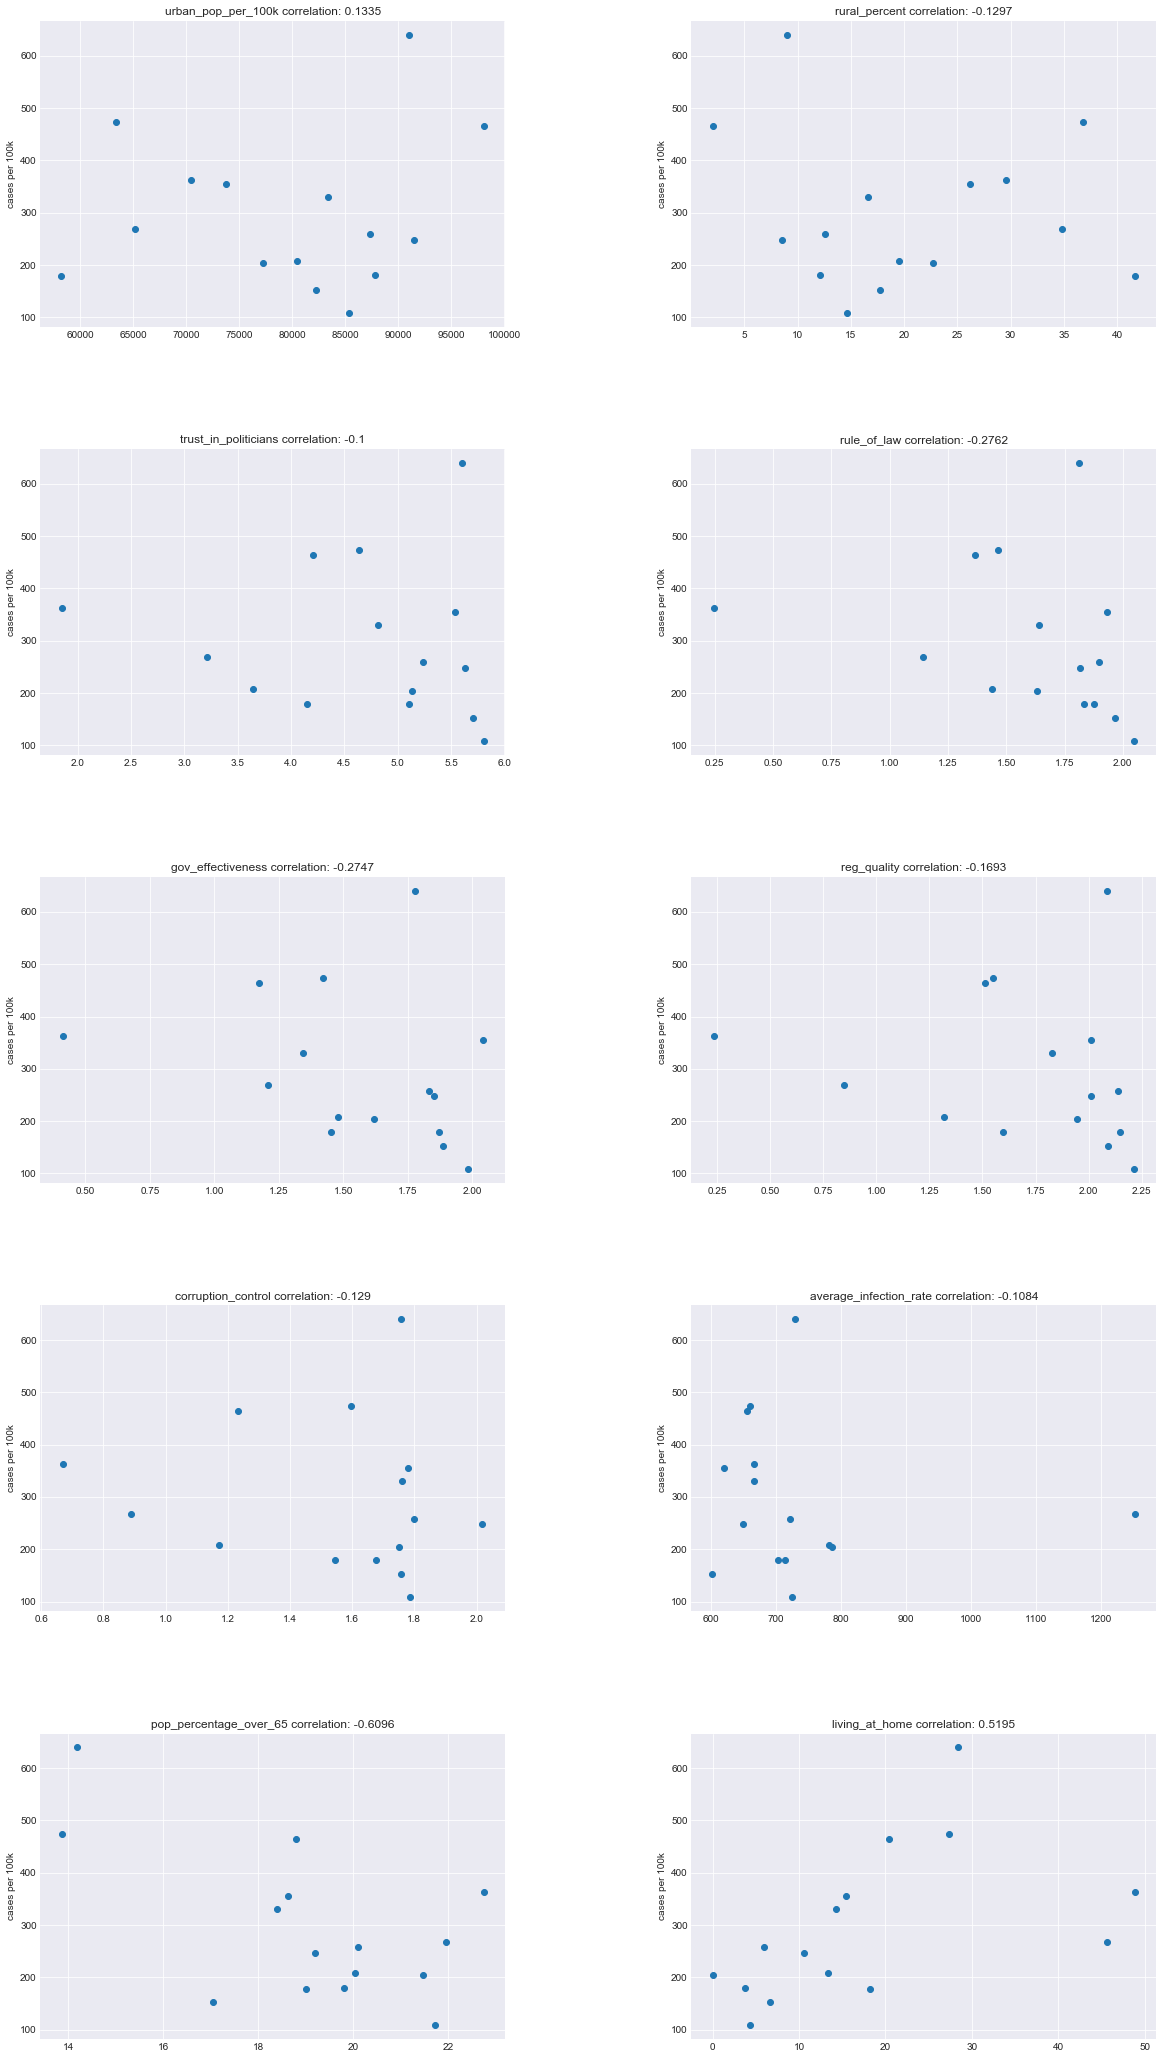

In [60]:
#Plotting all the different relationships

fig = plt.figure(figsize=(20,45))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1,len(list_of_interests)):
    category = list_of_interests[i]
    ax = fig.add_subplot(6, 2, i)
    corr = subset_present_day[[category,'total_cases_per_100k']].corr().loc[category]['total_cases_per_100k']
    ax.scatter(subset_present_day[category],subset_present_day['total_cases_per_100k'])
    ax.set_title(label=category + " correlation: " + str(corr.round(4)))
    ax.set_ylabel(ylabel="cases per 100k")

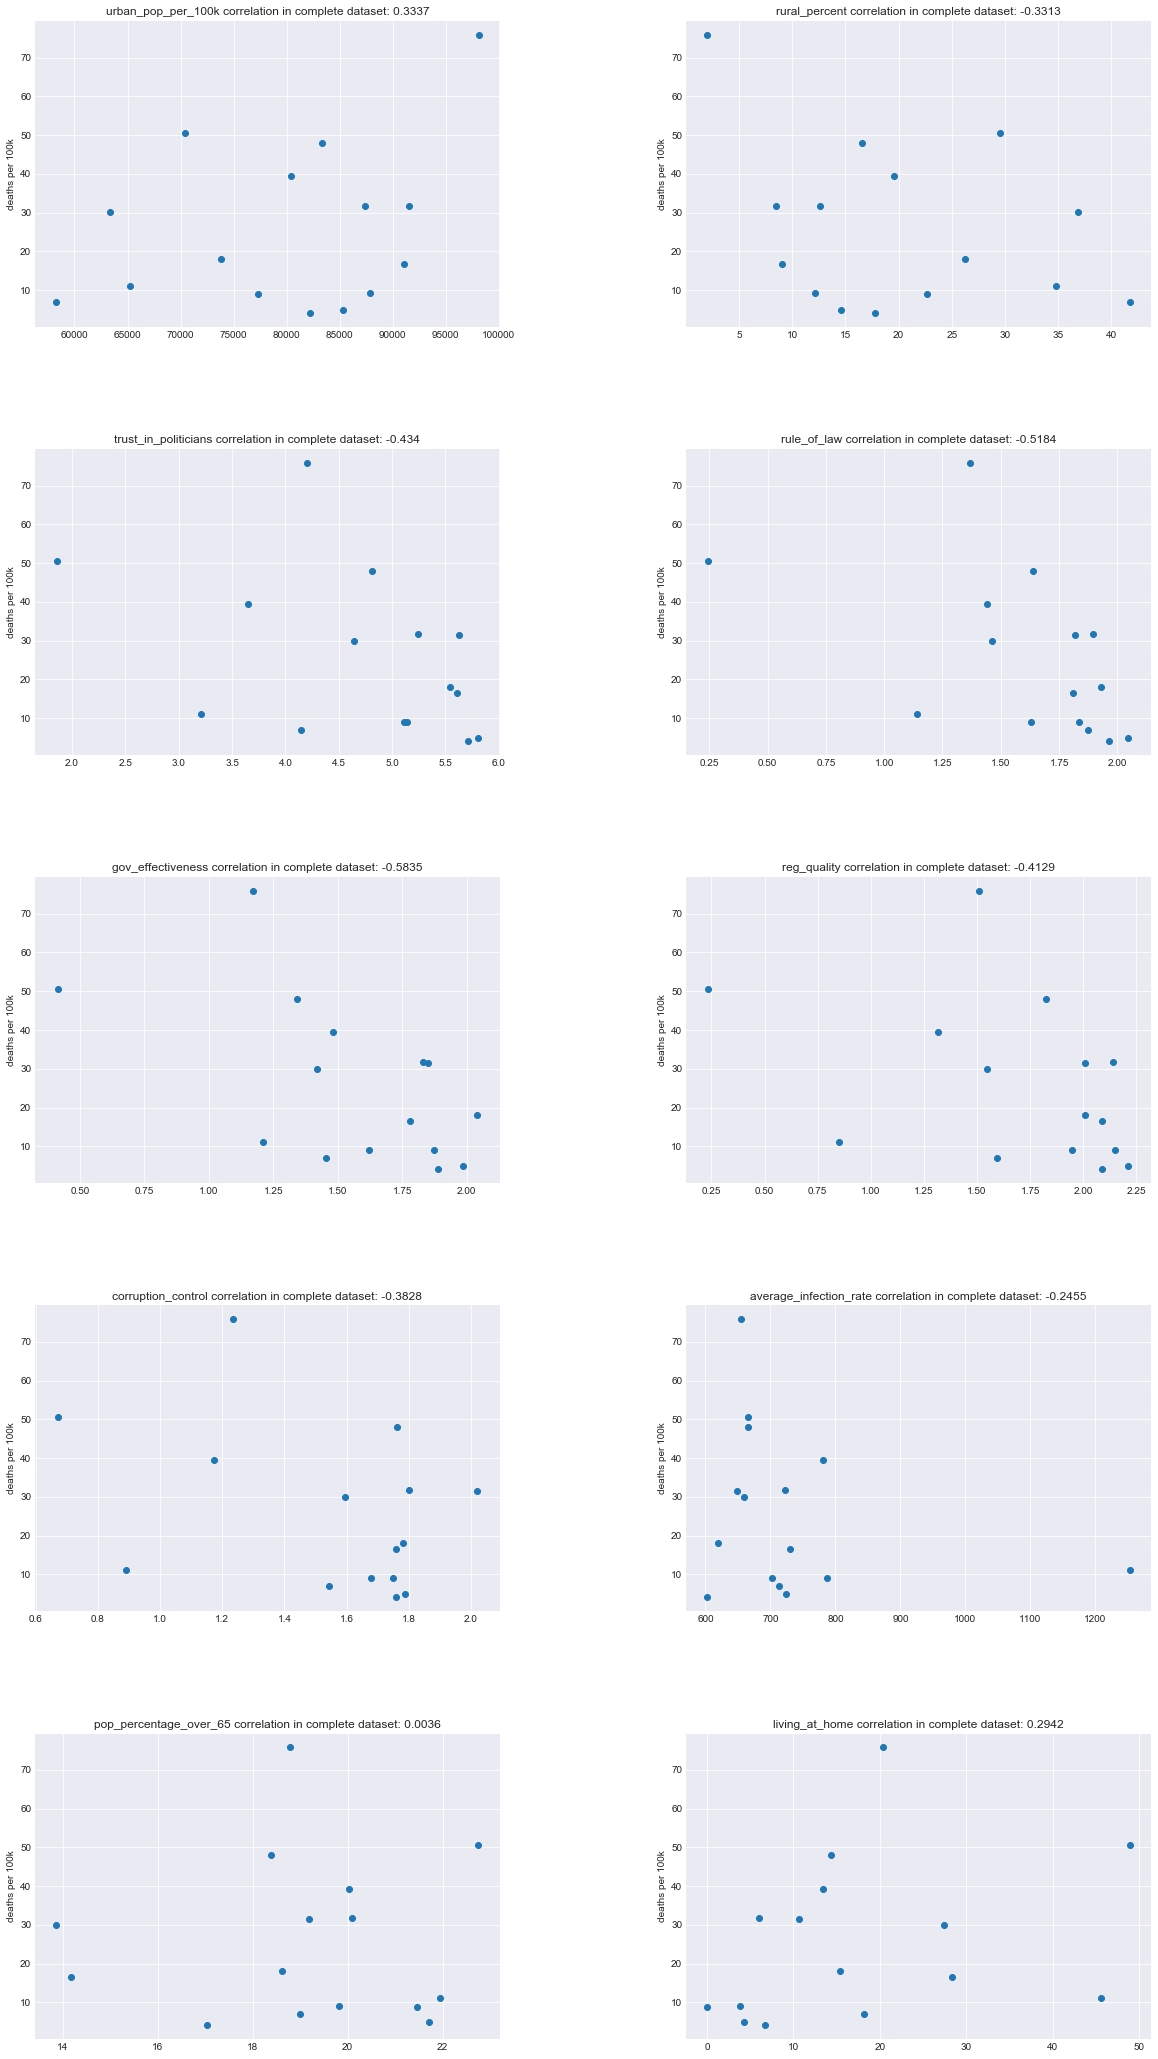

In [61]:
fig = plt.figure(figsize=(20,45))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1,len(list_of_interests)):
    category = list_of_interests[i]
    ax = fig.add_subplot(6, 2, i)
    corr = subset_present_day[[category,'total_deaths_per_100k']].corr().loc[category]['total_deaths_per_100k']
    ax.scatter(subset_present_day[category],subset_present_day['total_deaths_per_100k'])
    ax.set_title(label=category + " correlation in complete dataset: " + str(corr.round(4)))
    ax.set_ylabel(ylabel="deaths per 100k")

# Genre

The website falls within the magazine genre, as we present text and graphs/plots and maps between. Some of these are interactive, so our website also has a touch of the annotated map/graph genre. 

For visual narrative tools, we establish a sort of opening shot with the first graph of global COVID cases and deaths. 
Afterwards, we provide closeups of Europe and distinguish our features in the dataset with choropleth maps. 

For narrative structure, we rely on a linear path through the website. We start big; the graph of worldwide cases. Then we move in on Europe of some of the features we've looked at. Then, we go even more into detail by examining the interesting relationships we found througout our report. Lastly we zoom a bit out and examine the measures taken to combat COVID-19. 

In [15]:
date_set = full_set.sort_values('dateRep',ascending=True)

In [16]:
death_set = pd.DataFrame()
case_set = pd.DataFrame()

In [17]:
case_set['cases'] = date_set['cases'].cumsum()
death_set['deaths'] = date_set['deaths'].cumsum()
death_set['date'] = date_set['dateRep']
death_set.set_index('date',inplace=True)
case_set['date'] = date_set['dateRep']
case_set.set_index('date',inplace=True)

# Visualizations

We've made of the following visualizations:

* Line graphs, both simple and more advanced
* Scatter plots
* Choropleth maps
* Interactive barcharts (Bokeh)

We wanted to visualize the spread of the virus in a simple way, to establish the scene. For this we used the line graph. Then, with focus on Europe, we wanted to visualize how countries in Europe fare in terms of government effectiveness, degree of population living in urban areas and the percent of the population over 65. This was to show how Europe differs on some key factors, and prime the reader to start making connections; "Ah, Italy is not doing well in terms of government effectiveness, and they're doing really badly during the corona - might there be a connection?"

Next, we used scatterplots to visualize the relationships between our aggregated features, and the amount of reported deaths and cases per 100k citizens. We find scatterplots the best way to visualize a relationship, and show whether or not two variables might be connected. 

Lastly, we used Bokeh interactive charts to show the degree of differences between countries. This helped us visualize how many deaths per cases reported there are, and how these differ from country to country. Italy might have as many reported cases per 100k as another country, but their death-rate is sadly much higher. 


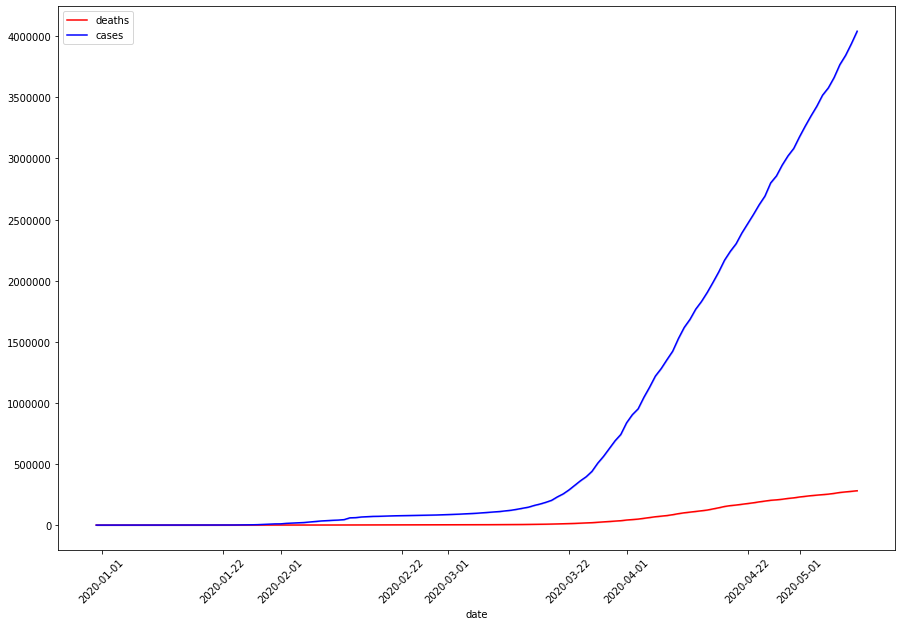

In [18]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.lineplot(data=death_set,palette=['red'])
sns.lineplot(data=case_set,palette=['blue'])
plt.savefig("worldwide.png")

In [19]:
subset['dateRep'] = pd.to_datetime(subset['dateRep'])

In [20]:
dk = subset.loc['DNK']
ita = subset.loc['ITA']
esp = subset.loc['ESP']
viet = full_set.loc['VNM']

In [21]:
viet['dateRep'] = pd.to_datetime(viet['dateRep'])

/Users/madsfjederholt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
#Markes indicate measures taken by governments, such as closing schools and borders

markers_dk = [dk.set_index('dateRep').index.get_loc('2020-02-27'),
           dk.set_index('dateRep').index.get_loc('2020-03-13'),
           dk.set_index('dateRep').index.get_loc('2020-03-14'),
           dk.set_index('dateRep').index.get_loc('2020-03-16')]

markers_ita = [ita.set_index('dateRep').index.get_loc('2020-01-31'),
               ita.set_index('dateRep').index.get_loc('2020-02-01'),
               ita.set_index('dateRep').index.get_loc('2020-03-07'),
               ita.set_index('dateRep').index.get_loc('2020-03-08'),]

markers_esp = [#First case
               esp.set_index('dateRep').index.get_loc('2020-01-30'),
                #Schools close
                esp.set_index('dateRep').index.get_loc('2020-03-12'),
                #All non essential shops close
                esp.set_index('dateRep').index.get_loc('2020-03-14'),
                #Borders close
               esp.set_index('dateRep').index.get_loc('2020-03-17')]

markers_vnm = [
    #First case
    viet.set_index('dateRep').index.get_loc('2020-01-16'),
    #Epidemic declared, many flights cancelled
    viet.set_index('dateRep').index.get_loc('2020-02-03'),
    #Schools close
    viet.set_index('dateRep').index.get_loc('2020-02-08')
]

In [23]:
legend_elements = [
    Line2D([0], [0], color='orange', lw=3, label='Denmark'),
    Line2D([0], [0], color='red', lw=3, label='Spain'),
    Line2D([0], [0], color='green', lw=3, label='Italy'),
    Line2D([0], [0], color='blue', lw=3, label='Vietnam'),
    #DK
    Line2D([0], [0], marker='X', color='orange',mfc="orange",mec="black", label='First case of COVID-19 detected (DK)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='D', color='orange',mfc="orange",mec="black", label='Secondary schools, public sector closes (DK)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='*', color='orange',mfc="orange",mec="black", label='Borders close (DK)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='orange',mfc="orange",mec="black", label='Primary schools, daycare closes (DK)', markerfacecolor='black', markersize=10),
    
    #ESP
    Line2D([0], [0], marker='X', color='red',mfc="red",mec="black", label='First case of COVID-19 detected (ESP)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='red',mfc="red",mec="black", label='All schools closed (ESP)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='D', color='red',mfc="red",mec="black", label='All non-essential shops close (ESP)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='*', color='red',mfc="red",mec="black", label='Border close (ESP)', markerfacecolor='black', markersize=10),
    
    #ITA
    Line2D([0], [0], marker='X', color='green',mfc="green",mec="black", label='First case of COVID-19 detected (ITA)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='s', color='green',mfc="green",mec="black", label='All flights to and from China cancelled (ITA)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='D', color='green',mfc="green",mec="black", label='All schools closed (ITA)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='v', color='green',mfc="green",mec="black", label='Official curfew/lockdown begins (ITA)', markerfacecolor='black', markersize=10),
    
    #VNM
    Line2D([0], [0], marker='X', color='blue',mfc="blue",mec="black", label='First case of COVID-19 detected (VNM)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='v', color='blue',mfc="blue",mec="black", label='COVID offically declared epidemic, flights cancelled and quarantines imposed (VNM)', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='blue',mfc="blue",mec="black", label='All schools closed (VNM)', markerfacecolor='black', markersize=10),]

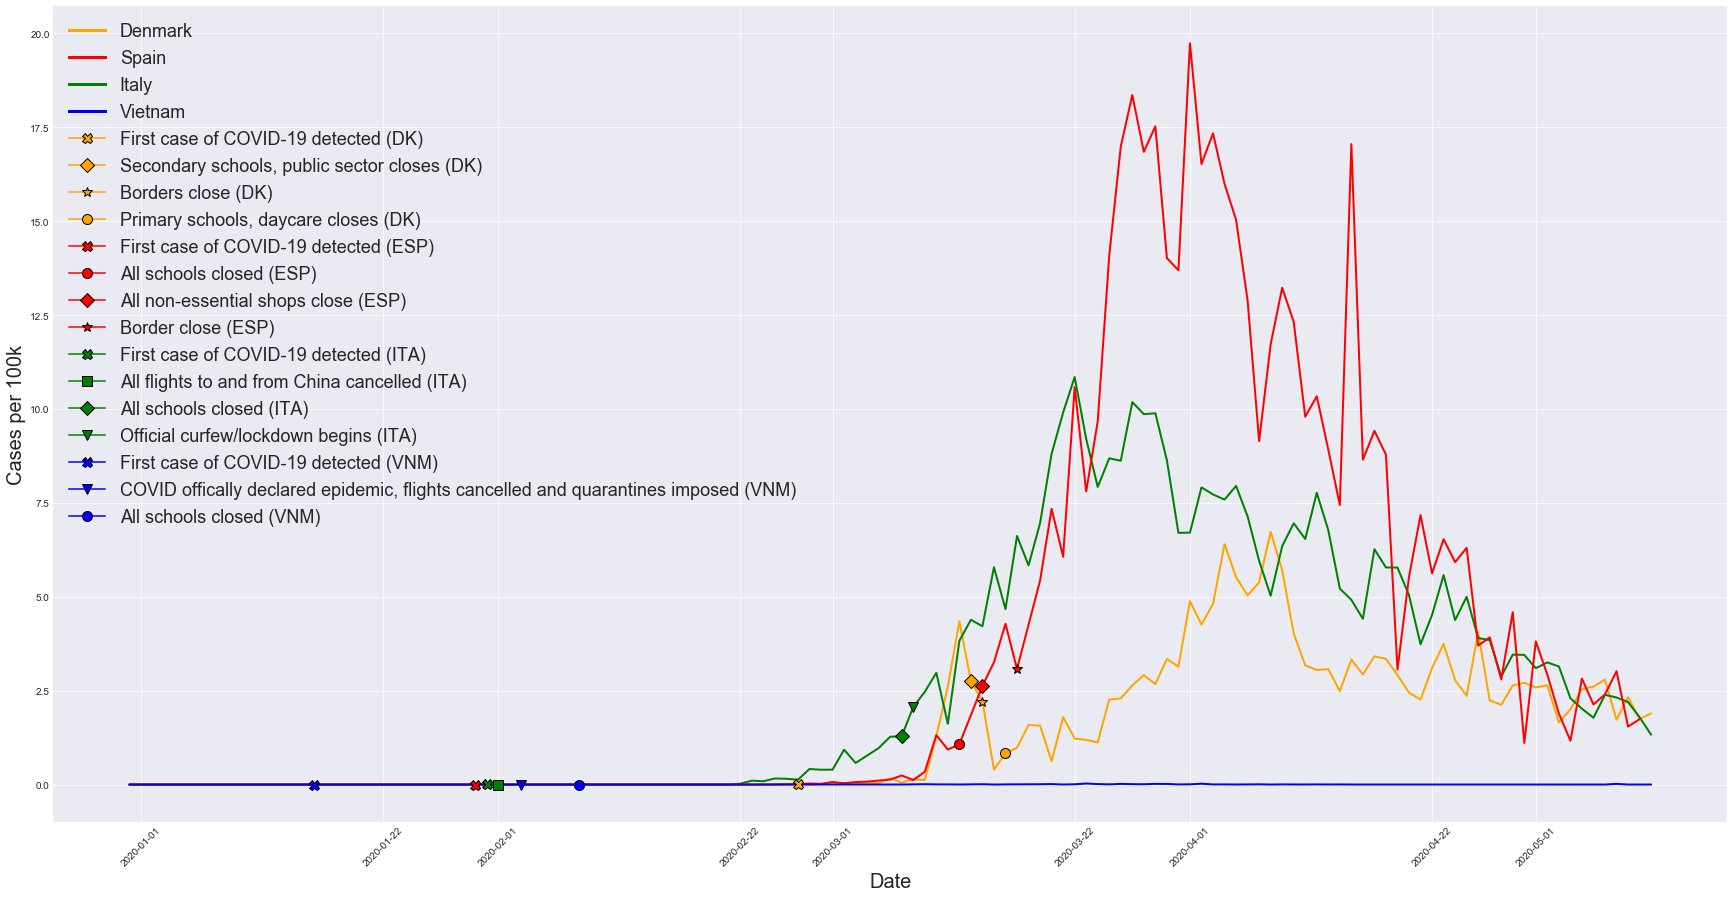

In [24]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(30,15))
plt.xlabel("Date",fontsize=20)
plt.ylabel("Cases per 100k",fontsize=20)
plt.plot( 'dateRep', 'cases_per_100k', data=dk, color='orange',marker ="D",mec="black",markevery=markers_dk[1],markersize=10, linewidth=2,label='Denmark')


plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green', linewidth=2,label='Italy')
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red', linewidth=2,label='Spain')
plt.plot( 'dateRep', 'cases_per_100k', data=viet, color='blue', linewidth=2,label='Vietnam')

#Markers DK
plt.plot( 'dateRep', 'cases_per_100k', data=dk, color='orange',marker ="o",mec="black",markevery=markers_dk[3],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=dk, color='orange',marker ="X",mec="black",markevery=markers_dk[0],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=dk, color='orange',marker ="*",mec="black",markevery=markers_dk[2],markersize=10, linewidth=0,label='Denmark')

#Markers ESP
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red',marker ="X",mec="black",markevery=markers_esp[0],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red',marker ="o",mec="black",markevery=markers_esp[1],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red',marker ="D",mec="black",markevery=markers_esp[2],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=esp, color='red',marker ="*",mec="black",markevery=markers_esp[3],markersize=10, linewidth=0,label='Denmark')

#Markers ITA
plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green',marker ="s",mec="black",markevery=markers_ita[1],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green',marker ="X",mec="black",markevery=markers_ita[0],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green',marker ="D",mec="black",markevery=markers_ita[2],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=ita, color='green',marker ="v",mec="black",markevery=markers_ita[3],markersize=10, linewidth=0,label='Denmark')

#Markers VNM
plt.plot( 'dateRep', 'cases_per_100k', data=viet, color='blue',marker ="X",mec="black",markevery=markers_vnm[0],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=viet, color='blue',marker ="v",mec="black",markevery=markers_vnm[1],markersize=10, linewidth=0,label='Denmark')
plt.plot( 'dateRep', 'cases_per_100k', data=viet, color='blue',marker ="o",mec="black",markevery=markers_vnm[2],markersize=10, linewidth=0,label='Denmark')

#plt.plot( 'dateRep', 'total_deaths', data=subset)
plt.xticks(rotation=45)
plt.xticks()
plt.legend(handles=legend_elements,loc=2,fontsize=18)
plt.savefig("timeline_plot.png")
plt.show()

In [25]:
day_sub = subset[subset['dateRep'] =='5/11/2020']

In [26]:
day_sub = day_sub[day_sub['living_at_home'] > 0]

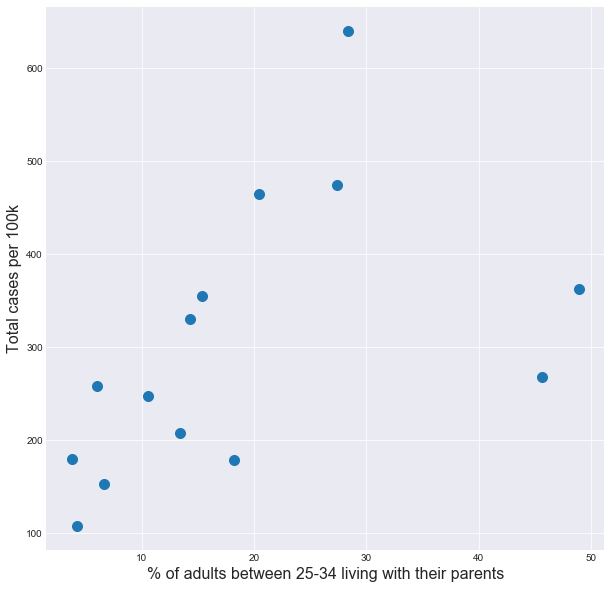

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(day_sub['living_at_home'],day_sub['total_cases_per_100k'],s=100)
plt.ylabel('Total cases per 100k',fontsize=16)
plt.xlabel('% of adults between 25-34 living with their parents',fontsize=16)
plt.savefig("cases_livinghome.png")

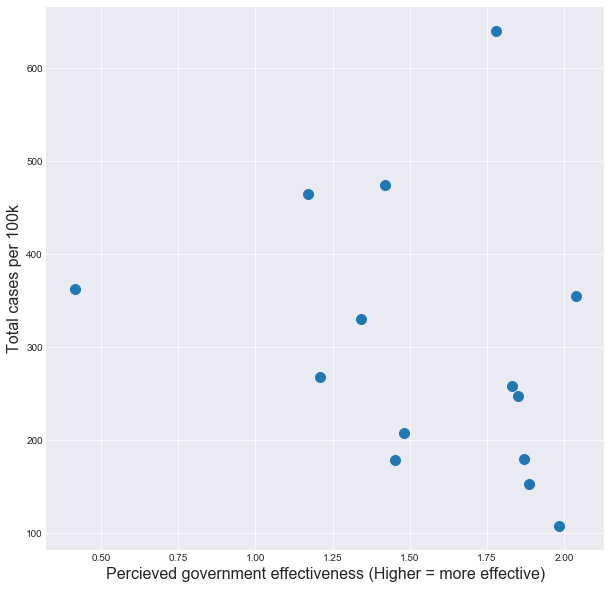

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(day_sub['gov_effectiveness'],day_sub['total_cases_per_100k'],s=100)
plt.ylabel('Total cases per 100k',fontsize=16)
plt.xlabel('Percieved government effectiveness (Higher = more effective)',fontsize=16)
plt.savefig("govern_cases.png")

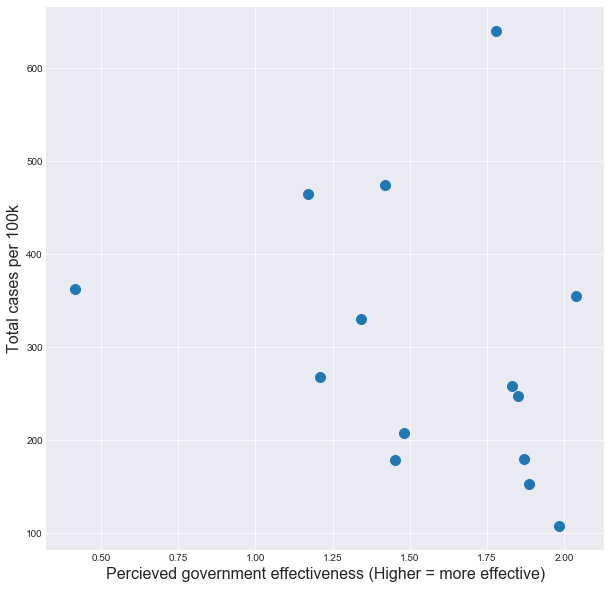

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(day_sub['gov_effectiveness'],day_sub['total_cases_per_100k'],s=100)
plt.ylabel('Total cases per 100k',fontsize=16)
plt.xlabel('Percieved government effectiveness (Higher = more effective)',fontsize=16)
plt.savefig("pop65_deaths.png")

# Choropleth maps

We wanted to give an overview of europe, so we created a layered choropleth maps, where you can choose between different statistics.

In [30]:
bins = list(full_set_present['pop_percentage_over_65'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

m2 = folium.Map(location=[50.5260, 15.2551], zoom_start=4,zoom_control=False,
               scrollWheelZoom=False,
               dragging=False,
               doubleClickZoom=False,
               min_zoom =4,
               max_zoom =4)
folium.Choropleth(
    geo_data=country_geo,
    name='Population over 65',
    data=full_set_present,
    columns=[full_set_present.index,'pop_percentage_over_65'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='pop_percentage_over_65',
    show = False
).add_to(m2)


In [31]:
bins = list(full_set_present['gov_effectiveness'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

#m2 = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='Government Effectiveness',
    data=full_set_present,
    columns=[full_set_present.index,'gov_effectiveness'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='Tourism',
    show = False
).add_to(m2)

In [32]:
bins = list(full_set_present['urban_pop_per_100k'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

#m2 = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='Urban Population',
    data=full_set_present,
    columns=[full_set_present.index,'urban_pop_per_100k'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='Urban Population',
    smooth_factor = 0.01
).add_to(m2)
folium.LayerControl(collapsed=False).add_to(m2)

In [33]:
m2

In [ ]:
m2.save("../Final project/website/folium/map2.html")

# Bookeh plots

We wanted to show a comparison between countries in terms of cases and deaths, and we wanted to show some other statistics as well.

We decided to do this through bookeh bar charts.

In [38]:
from bokeh.io import output_file, show, save, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import FactorRange
from bokeh.plotting import figure
from bokeh.models import Legend
from bokeh.resources import CDN
from bokeh.embed import file_html

output_notebook() # for outputting to notebook
source = ColumnDataSource(full_set_present) # data importing
colors = ["#a83232", "#3283a8", "#a86932" , "#a8a232", "#7da832", "#32a83c"]#, "#32a87f", "#3283a8","#324aa8", "#5d32a8", "#9432a8", "#a83273", "#a83248", "#b59399", "#2e292a"]
data_to_show = ['total_deaths_per_100k','total_cases_per_100k']

selected_countries= ['AUT','BEL','DNK','FIN','FRA','DEU','IRL','ITA','LUX','NLD','PRT','ESP','SWE','GBR']

c = full_set_present.index.values.tolist()
countries=[]
for country in c:
    country =str(country)
    if country in selected_countries:
        countries.append(country)


p = figure(x_range = FactorRange(factors=countries), plot_height=400, plot_width=900, title="Countries, cases and deaths", 
           toolbar_location=None,  y_range = [10 ** 0, 640])
items=[]
bar ={} # to store vbars

for indx,i in enumerate(data_to_show):
    
    bar[i] = p.vbar(x='countryterritoryCode', top =i,  source= source, visible = True, width= 0.8, color =colors[indx], fill_alpha =0.6,bottom=0.01) 
    items.append((i, [bar[i]]))
    
#p.legend.click_policy="hide" ### assigns the click policy (you can try to use ''hide'
#p.legend.location = 'top_left'

legend = Legend(items=items, location=(0,0))
legend.click_policy="hide"

p.add_layout(legend, 'right')
p.xaxis.axis_label = "Country"
p.yaxis.axis_label = "Total Cases/Deaths"

#bar['deaths_per_100k'].visible = True 

show(p) #displays your plot


Loading BokehJS ...

In [39]:
#save the plot to html file

output_file("../Final project/website/folium/bookeh_bar_plot.html", mode='inline')
save(p)

'/Users/madsfjederholt/Documents/SocialData02806_2020-master/SocialData02806_2020/Final project/website/folium/bookeh_bar_plot.html'

In [42]:
full_set_present.head()

,dateRep,cases,deaths,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,total_deaths_per_100k,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,living_at_home
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
AFG,2020-05-11,369,5,Afghanistan,AF,37172386.0,Asia,120,4402,0.323,...,25495.001,74.505,1.000,-1.668478,-1.457285,-1.496648,-1.132634,614.634146,2.584927,0.0
ALB,2020-05-11,12,0,Albania,AL,2866376.0,Europe,31,868,1.082,...,60318.988,39.681,3.266,-0.392243,0.114788,-0.521867,0.281710,1278.125000,13.744736,0.0
DZA,2020-05-11,165,8,Algeria,DZ,42228429.0,Africa,502,5723,1.189,...,72629.001,27.371,2.824,-0.775309,-0.443925,-0.636465,-1.263752,654.687500,6.362497,0.0
AND,2020-05-11,1,0,Andorra,AD,77006.0,Europe,48,755,62.333,...,88061.969,11.938,1.000,1.607738,1.944976,1.238614,1.187921,991.525424,NaN,0.0
AGO,2020-05-11,2,0,Angola,AO,30809762.0,Africa,2,45,0.006,...,65513.998,34.486,NaN,-1.048023,-1.052086,-1.144541,-0.999813,196.078431,2.216374,0.0


In [53]:
output_notebook() # for outputting to notebook
source = ColumnDataSource(full_set_present) # data importing
colors = ["#a8a232", "#7da832", "#32a83c"]#, "#32a87f", "#3283a8","#324aa8", "#5d32a8", "#9432a8", "#a83273", "#a83248", "#b59399", "#2e292a"]
data_to_show = ['urban_pop_per_100k','pop_percentage_over_65_per_100k','tourists_per_100k']

selected_countries= ['AUT','BEL','DNK','FIN','FRA','DEU','IRL','ITA','LUX','NLD','PRT','ESP','SWE','GBR']

c = full_set_present.index.values.tolist()
countries=[]
for country in c:
    country =str(country)
    if country in selected_countries:
        countries.append(country)


p2 = figure(x_range = FactorRange(factors=countries), plot_height=400, plot_width=900, title="Country statistics", 
           toolbar_location=None,  y_range = [0, 3.5*(10 **5)])
items=[]
bar ={} # to store vbars

for indx,i in enumerate(data_to_show):
    
    bar[i] = p2.vbar(x='countryterritoryCode', top =i,  source= source, visible = True, width= 0.8, color =colors[indx], fill_alpha =0.6,bottom=0.01) 
    items.append((i, [bar[i]]))
    
#p.legend.click_policy="hide" ### assigns the click policy (you can try to use ''hide'
#p.legend.location = 'top_left'

legend = Legend(items=items, location=(0,0))
legend.click_policy="hide"

p2.add_layout(legend, 'right')
p2.xaxis.axis_label = "Country"
#p.yaxis.axis_label = "Total Cases"

bar['urban_pop_per_100k'].visible = True 

show(p2) #displays your plot


Loading BokehJS ...

In [ ]:
#save the plot to html file

output_file("../Final project/website/folium/bookeh_bar_plot2.html", mode='inline')
save(p2)

# Discussion

We managed to find some interesting relationships between the features in the dataset, and at least failed to disprove some of our hypothesis'. Mainly, we're very interested in the relationship between reported cases and the amount of adults living at home, as this seems intuitively relevant. 

The aggregation of datasets, although it's taken a good amount of work, resulted in some good analysis. 
However, we also discovered that the world (unsurprisingly) is very, very complicated and boiling down the spread of the virus to one or two (or four or five) features is unrealistic. As correlation != causation, we can only really establish vague link between the data. It also proved hard to analyze a dataset consisting of every country on earth, they simply differ too much. This is why we focused on Western Europe. 

Lastly, we might've bit off more than we could chew. But we did find some cool insights, and nevertheless learned a whole lot along the way.

Improvements include better use of visuals, and more varied ways of presenting correlations. 

# Contributions

* Interactive visualizations and aggregating: Magnus Peter Eilersen (s144210)
* Text for website and locating interesting datasets: Martin Alexander Wiesner Krøll (s153455)
* Collecting data, aggregating datasets, analyzing data and visualizing correlations: Mads Fjederholt (s162889)
